    Use log soft max because it is numericaly more stable!

    It is worse to class a customer as good when they are bad, than it is to class a customer as bad when they are good.
    

    Are there Biases ???? (i.e. race, gender, age, etc.) 

    Is foreign worker okay to use as a feature, because it could be a bias?
    
    How to handle unbalance in data?

**Dataset Citation:** <br>
Hofmann,Hans. (1994). Statlog (German Credit Data). UCI Machine Learning Repository. https://doi.org/10.24432/C5NC77.

# Portfolio-Exam 

#### Inports

In [258]:
# Imports 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree, metrics as ms
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
torch.set_default_dtype(torch.float)



#### Variables 

In [259]:
random_seed = 42
torch.manual_seed(42)

## Task 1 - Story

## Task 2 - The Data



|Variable Name| Role| Type| Demographic| Description| Units| Missing Values|
|---|---|---|---|---|---|---|
|Attribute1|	Feature|	Categorical|		        |Status of existing checking account| |  no|
|Attribute2|	Feature|	Integer|		            |Duration|	months|	no|
|Attribute3|	Feature|	Categorical|		        |Credit history|	|	no|
|Attribute4|	Feature|	Categorical|		        |Purpose|	|	no|
|Attribute5|	Feature|	Integer|		            |Credit amount|	|	no|
|Attribute6|	Feature|	Categorical|		        |Savings account/bonds|	|	no|
|Attribute7|	Feature|	Categorical|    Other|	Present employment since|		|no|
|Attribute8|	Feature|	Integer|		    |Installment rate in percentage of disposable income|		|no|
|Attribute9|	Feature|	Categorical|    Marital Status|	Personal status and sex|		|no|
|Attribute10|	Feature|	Categorical|		|Other debtors / guarantors|		|no|
|Attribute11|	Feature|	Integer|		|Present residence since|	|no|
|Attribute12|	Feature|	Categorical|		|Property|		|no|
|Attribute13|	Feature|	Integer|	Age	|Age    |years|	no|
|Attribute14|	Feature|	Categorical|		|Other installment plans|		|no|
|Attribute15|	Feature|    Categorical|	Other|	Housing|		|no|
|Attribute16|	Feature|	Integer|		|Number of existing credits at this bank|		|no|
|Attribute17|	Feature|	Categorical|	Occupation|	Job	|	|no|
|Attribute18|	Feature|	Integer|		|Number of people being liable to provide maintenance for| |no|
|Attribute19|	Feature|	Binary|		|Telephone|		|no|
|Attribute20|	Feature|	Binary|	Other	|foreign worker|	|no|
|class|	Target|	Binary|		|1 = Good, 2 = Bad|		|no|

In [260]:


# Load the dataset
df = pd.read_csv('data/german.data', delim_whitespace=True, header=None)

# Define column names
columns = [
    "Status_of_existing_checking_account", "Duration_in_months", "Credit_history", 
    "Purpose", "Credit_amount", "Savings_account_bonds", "Present_employment_since", 
    "Installment_rate_as_percentage_of_disposable_income", "Personal_status_and_sex", 
    "Other_debtors_guarantors", "Present_residence_since", "Property", "Age_in_years", 
    "Other_installment_plans", "Housing", "Number_of_existing_credits_at_this_bank", 
    "Job", "Number_of_people_being_liable_to_provide_maintenance_for", "Telephone", 
    "Foreign_worker", "Class"
]

# Assign column names to the dataframe
df.columns = columns

# Define the mapping for categorical values
mappings = {
    "Status_of_existing_checking_account": {
        "A11": "< 0 DM", "A12": "0 <= ... < 200 DM", "A13": ">= 200 DM", "A14": "no checking account"
    },
    "Credit_history": {
        "A30": "no credits/all credits paid back duly", "A31": "all credits at this bank paid back duly", 
        "A32": "existing credits paid back duly till now", "A33": "delay in paying off in the past", 
        "A34": "critical account/other credits existing"
    },
    "Purpose": {
        "A40": "car (new)", "A41": "car (used)", "A42": "furniture/equipment", 
        "A43": "radio/television", "A44": "domestic appliances", "A45": "repairs", 
        "A46": "education", "A48": "retraining", "A49": "business", "A410": "others"
    },
    "Savings_account_bonds": {
        "A61": "< 100 DM", "A62": "100 <= ... < 500 DM", "A63": "500 <= ... < 1000 DM", 
        "A64": ">= 1000 DM", "A65": "unknown/ no savings account"
    },
    "Present_employment_since": {
        "A71": "unemployed", "A72": "< 1 year", "A73": "1 <= ... < 4 years", 
        "A74": "4 <= ... < 7 years", "A75": ">= 7 years"
    },
    "Personal_status_and_sex": {
        "A91": "male : divorced/separated", "A92": "female : divorced/separated/married", 
        "A93": "male : single", "A94": "male : married/widowed", "A95": "female : single"
    },
    "Other_debtors_guarantors": {
        "A101": "none", "A102": "co-applicant", "A103": "guarantor"
    },
    "Property": {
        "A121": "real estate", "A122": "building society savings agreement/life insurance", 
        "A123": "car or other", "A124": "unknown / no property"
    },
    "Other_installment_plans": {
        "A141": "bank", "A142": "stores", "A143": "none"
    },
    "Housing": {
        "A151": "rent", "A152": "own", "A153": "for free"
    },
    "Job": {
        "A171": "unemployed/ unskilled - non-resident", "A172": "unskilled - resident", 
        "A173": "skilled employee / official", "A174": "management/ self-employed/ highly qualified employee/ officer"
    },
    "Telephone": {
        "A191": "none", "A192": "yes, registered under the customer's name"
    },
    "Foreign_worker": {
        "A201": "yes", "A202": "no"
    },
    "Class": {
        1: "Good", 2: "Bad"
    }
}

# Apply the mapping to the dataframe
for column, mapping in mappings.items():
    df[column] = df[column].map(mapping)

/tmp/ipykernel_4272/3747983735.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('data/german.data', delim_whitespace=True, header=None)


In [261]:
# Get shape
print(df.shape)

(1000, 21)


In [262]:
df.head()

,Status_of_existing_checking_account,Duration_in_months,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_as_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,...,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,Foreign_worker,Class
0,< 0 DM,6,critical account/other credits existing,radio/television,1169,unknown/ no savings account,>= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customer's name",yes,Good
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,< 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad
2,no checking account,12,critical account/other credits existing,education,2096,< 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good
3,< 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,Good
4,< 0 DM,24,delay in paying off in the past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad


**Dataset Citation:** <br>
Hofmann,Hans. (1994). Statlog (German Credit Data). UCI Machine Learning Repository. https://doi.org/10.24432/C5NC77.

## Task 3 - IDA

In [263]:
def calc_dist_class(data, name, binary):
    """Calculate the distribution of the classes in the dataset.
    Args:
        data (dataframe): dataset.
        name (string): name of the dataset.
        binary (bool): True if the dataset is binary, False if not.
    Returns:
        None
    """
    if binary:
        class_counts = np.bincount(data)
    else: 
        class_counts = data['Class'].value_counts()

    class_frequencies = np.array(class_counts) / len(data)
    print(f'The number of good transactions in {name} is: {class_counts.iloc[0]} and the number of bad transactions in {name} is: {class_counts.iloc[1]}.')
    print(f'The percentage of good transactions in {name} is: {class_frequencies[0]*100:.0f}% and percentage of bad transactions in {name} is: {class_frequencies[1]*100:.0f}%.')

In [264]:
def initial_data_analysis(df, name):
    """
    Gives information about the dataframe for a quick overview.
    Args:
        df (pandas.DataFrame): The dataframe to be analysed.
        name (str): The name of the dataframe.
    Returns:
        None
    """
    print(f'Initial data analysis for {name}:\n')
    print(f'Shape: {df.shape}\n')

    # Look at the distribution of the target variable
    calc_dist_class(df, name, False)

    column_name = []
    dtype = []
    count = []
    unique = []
    missing_values = []
    # Create a list of column names, data types, number of non-null values, number of unique values, and number of missing values
    for column in df.columns:
        column_name.append(column)
        dtype.append(df[column].dtype)
        count.append(df[column].count())
        unique.append(df[column].nunique())
        missing_values.append(df[column].isna().sum())

    # Create a dataframe consisting of the lists
    overview_values = pd.DataFrame({'column_name': column_name, 'dtype': dtype, 'count': count, 'unique': unique, 'missing_values': missing_values})
    display(overview_values)
    
    # Sum up all the values in missing_values to get the total number of missing values
    missing_val = sum(missing_values)
    total_cells = np.prod(df.shape)
    print(f'Sum of missing values: {missing_val}\n') 
    print(f'Percentage of null values: {missing_val/total_cells*100:.2f}%\n') 

    # Check for duplicates 
    if df.duplicated().sum() == 0:
        print('No duplicates found.\n')
    else:
        print('Duplicates found.\n')

    print('Head:')
    display(df.head())

    # Get descriptive statistics for the numerical columns
    print('Descriptive statistics for numerical columns:')
    display(df.describe().round(2))
    print(' ') # Do a linebreak

In [265]:
# Perform initial data analysis
initial_data_analysis(df, 'German Credit Data')

Initial data analysis for German Credit Data:

Shape: (1000, 21)

The number of good transactions in German Credit Data is: 700 and the number of bad transactions in German Credit Data is: 300.
The percentage of good transactions in German Credit Data is: 70% and percentage of bad transactions in German Credit Data is: 30%.


,column_name,dtype,count,unique,missing_values
0,Status_of_existing_checking_account,object,1000,4,0
1,Duration_in_months,int64,1000,33,0
2,Credit_history,object,1000,5,0
3,Purpose,object,1000,10,0
4,Credit_amount,int64,1000,921,0
5,Savings_account_bonds,object,1000,5,0
6,Present_employment_since,object,1000,5,0
7,Installment_rate_as_percentage_of_disposable_i...,int64,1000,4,0
8,Personal_status_and_sex,object,1000,4,0
9,Other_debtors_guarantors,object,1000,3,0


Sum of missing values: 0

Percentage of null values: 0.00%

No duplicates found.

Head:


,Status_of_existing_checking_account,Duration_in_months,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_as_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,...,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,Foreign_worker,Class
0,< 0 DM,6,critical account/other credits existing,radio/television,1169,unknown/ no savings account,>= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customer's name",yes,Good
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,< 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad
2,no checking account,12,critical account/other credits existing,education,2096,< 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good
3,< 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,Good
4,< 0 DM,24,delay in paying off in the past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad


Descriptive statistics for numerical columns:


,Duration_in_months,Credit_amount,Installment_rate_as_percentage_of_disposable_income,Present_residence_since,Age_in_years,Number_of_existing_credits_at_this_bank,Number_of_people_being_liable_to_provide_maintenance_for
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,20.90,3271.26,2.97,2.84,35.55,1.41,1.16
std,12.06,2822.74,1.12,1.10,11.38,0.58,0.36
min,4.00,250.00,1.00,1.00,19.00,1.00,1.00
25%,12.00,1365.50,2.00,2.00,27.00,1.00,1.00
50%,18.00,2319.50,3.00,3.00,33.00,1.00,1.00
75%,24.00,3972.25,4.00,4.00,42.00,2.00,1.00
max,72.00,18424.00,4.00,4.00,75.00,4.00,2.00


#### Visualize the distribution of the Classes

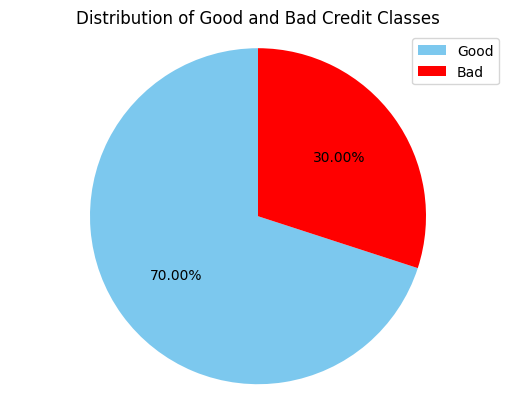

In [266]:
# Count the number of samples in each class
class_counts = df['Class'].value_counts()

# Define colors for the pie slices
colors = ['#7cc8ee', 'red']

# Create a pie chart
fig, ax = plt.subplots()
pie = ax.pie(class_counts, labels=['Good', 'Bad'], colors=colors, autopct='%1.2f%%', startangle=90)
for label in pie[1]: # Set the label color to white so it's invisible
    label.set_color('white')
ax.legend(pie[0], ['Good', 'Bad'], loc='upper right') # Add a legend
ax.set_title('Distribution of Good and Bad Credit Classes') # Add a title
ax.axis('equal')
plt.show()



#### Visualize the distribution of the credit amount

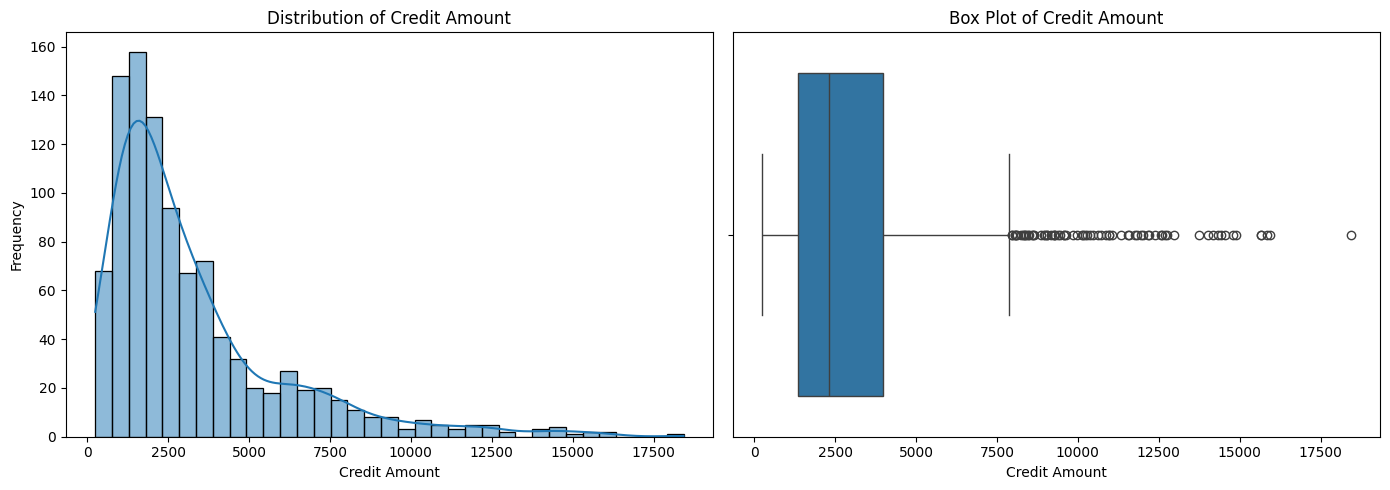

In [267]:
# Set up the matplotlib figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of Credit Amount
sns.histplot(df['Credit_amount'], kde=True, ax=axs[0])
axs[0].set_title('Distribution of Credit Amount')
axs[0].set_xlabel('Credit Amount')
axs[0].set_ylabel('Frequency')

# Box plot of Credit Amount
sns.boxplot(x=df['Credit_amount'], ax=axs[1])
axs[1].set_title('Box Plot of Credit Amount')
axs[1].set_xlabel('Credit Amount')

plt.tight_layout()
plt.show()

#### Visualize the distribution of the duration of the credit

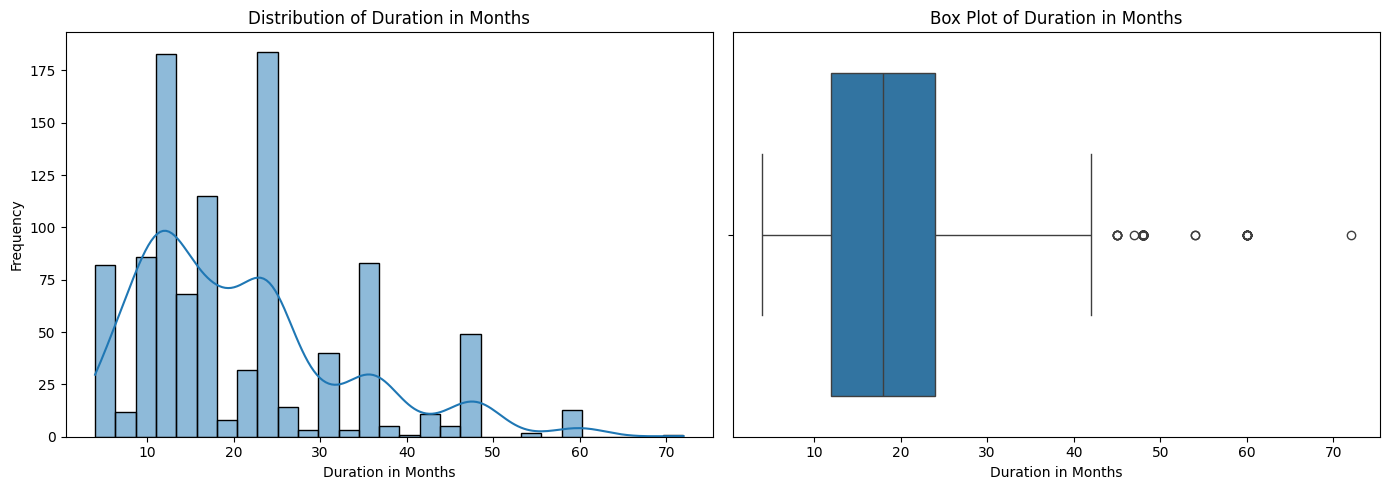

In [268]:
# Set up the matplotlib figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of Duration in Months
sns.histplot(df['Duration_in_months'], kde=True, ax=axs[0])
axs[0].set_title('Distribution of Duration in Months')
axs[0].set_xlabel('Duration in Months')
axs[0].set_ylabel('Frequency')

# Box plot of Duration in Months
sns.boxplot(x=df['Duration_in_months'], ax=axs[1])
axs[1].set_title('Box Plot of Duration in Months')
axs[1].set_xlabel('Duration in Months')

plt.tight_layout()
plt.show()


#### Look at the distribution of the amount of credit of each class

In [269]:
display(df.groupby('Class')['Credit_amount'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,3938.13,3535.82,433.0,1352.5,2574.5,5141.50,18424.0
Good,700.0,2985.46,2401.47,250.0,1375.5,2244.0,3634.75,15857.0


#### Look at the distribution of the duration in months of each class

In [270]:
display(df.groupby('Class')['Duration_in_months'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,24.86,13.28,6.0,12.0,24.0,36.0,72.0
Good,700.0,19.21,11.08,4.0,12.0,18.0,24.0,60.0


## Task 4 - EDA, Preprocessing

#### Dealing with Imbalanced Classes

The complete dataset is imbalanced, with 70% of the data labeled as good credit and 30% labeled as bad credit. This will be addressed in the following tasks, inside the respective pipeline. 

#### Problematic Features

Columns that are problematic because of potential discrimination and bias concerns:

- **Personal_status_and_sex:** This column combines personal status and sex, which could introduce gender bias into the model.

- **Age_in_years:** Age is a sensitive attribute and could lead to age discrimination.

- **Foreign_worker:** This column indicates whether the applicant is a foreign worker, which could lead to discrimination based on nationality.

Because of these concerns, this column will be dropped from the dataset.

In [271]:
# Drop columns because of discriminatory concerns
df.drop(columns=["Personal_status_and_sex", "Age_in_years", "Foreign_worker"], inplace=True)
df.shape

(1000, 18)

#### Encoding Categorical Variables

In [272]:
# Encoding categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.shape

(1000, 44)

After deciding the categorical columns, the dataset now contains 44 features, since each categorical column was expanded into multiple columns using one-hot encoding.

#### Separating the Target Variable

In [273]:
# Separating features and target variable
X = df_encoded.drop('Class_Good', axis=1)  # 'Class_Good' is the target variable after encoding
y = df_encoded['Class_Good']

In [274]:
X.shape, y.shape

((1000, 43), (1000,))

#### Split the Data

In [275]:
# Split data into train (42%), validation (18%), and test (40%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=random_seed)
# From the remaining 60%, the validation set should be 18% of the total, therefore the validation set size need to be set to 0.18/0.6 = 0.3!!!!
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.30, shuffle=True, random_state=random_seed)

#### Scale the data

In [276]:
x_scaler = MinMaxScaler()
# No y_scaler needed since it is a classification problem and not a regression problem 

In [277]:
# Fit and transform the features
x_scaler.fit(X_train_full)
X_train_sc = x_scaler.transform(X_train)
X_val_sc = x_scaler.transform(X_val)
X_test_sc = x_scaler.transform(X_test)

Ensure that the data is split into the wanted proportions.

In [278]:
# Calculate the size of test, train and val sets and calculate percentage of each
test_size = len(X_test_sc)
train_size = len(X_train_sc)
val_size = len(X_val_sc)

test_size_percent = test_size / (test_size + train_size + val_size) * 100
train_size_percent = train_size / (test_size + train_size + val_size) * 100
val_size_percent = val_size / (test_size + train_size + val_size) * 100

# Print the size of test, train and val sets and percentage of each
print("Test set size: ", test_size)
print("Train set size: ", train_size)
print("Validation set size: ", val_size)
print(f"Test set size percentage: {test_size_percent} %")
print(f"Train set size percentage: {train_size_percent} %")
print(f"Validation set size percentage: {val_size_percent} %")

Test set size:  400
Train set size:  420
Validation set size:  180
Test set size percentage: 40.0 %
Train set size percentage: 42.0 %
Validation set size percentage: 18.0 %


#### Create Tensors

In [279]:
# Convert to PyTorch tensors
X_train_sc_tens = torch.tensor(X_train_sc, dtype=torch.float32)
y_train_tens = torch.tensor(y_train.values, dtype=torch.long)
X_val_sc_tens = torch.tensor(X_val_sc, dtype=torch.float32)
y_val_tens = torch.tensor(y_val.values, dtype=torch.long)
X_test_sc_tens = torch.tensor(X_test_sc, dtype=torch.float32)
y_test_tens = torch.tensor(y_test.values, dtype=torch.long)

Ensure that the tensors are created with the correct dimensions.

In [280]:
# Check the sizes of the tensors
print("Train set size:", X_train_sc_tens.size(), y_train_tens.size())
print("Validation set size:", X_val_sc_tens.size(), y_val_tens.size())
print("Test set size:", X_test_sc_tens.size(), y_test_tens.size())

Train set size: torch.Size([420, 43]) torch.Size([420])
Validation set size: torch.Size([180, 43]) torch.Size([180])
Test set size: torch.Size([400, 43]) torch.Size([400])


## Task 5 -Baseline

In [281]:
# Dataframe to store the results
df_results =  pd.DataFrame()

# Function evaluate the performance of a classifier
def add_results_to_df(df_results, model, y_train, y_test, y_train_pred, y_test_pred):
    '''
    Function to add the results of a model to a dataframe
    Args:
        df_results : DataFrame : a dataframe to store the results
        model : str : the name of the model
        dataset : str : the name of the dataset
        y_train : array : the true labels of the training set
        y_test : array : the true labels of the test set
        y_pred_train : array : the predicted labels of the training set
        y_pred_test : array : the predicted labels of the test set
    Returns:
        DataFrame : the dataframe with the added results
    '''
    for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
        df_results= pd.concat([df_results, pd.DataFrame([{
            "Model": model, 
            "Dataset": dataset,
            "Accuracy": ms.accuracy_score(actual, predicted),
            "Precision": precision_score(actual, predicted),
            "Recall": recall_score(actual, predicted),
            "F1_Score":f1_score(actual, predicted),
            "Confusion_Matrix": confusion_matrix(actual, predicted)
        }])], ignore_index=True)   
    return df_results

In [282]:
# Calculate the mean and standard deviation for each metric and model
def calculate_mean_std(df_results):
    """
    Calculate the mean and standard deviation for each metric and model.
    Args:
        df_results : DataFrame containing the results with columns 
                ['Model', 'Dataset', 'Precision', 'Recall', 'F1_Score', Confusion_Matrix']
    Returns:
        summary_df : DataFrame containing the mean and standard deviation for each metric and model
    """
    summary_df = df_results.groupby(['Model', 'Dataset']).agg(
        Accuracy_mean=('Accuracy', 'mean'),
        Accuracy_std=('Accuracy', 'std'),
        Precision_mean=('Precision', 'mean'),
        Precision_std=('Precision', 'std'),
        Recall_mean=('Recall', 'mean'),
        Recall_std=('Recall', 'std'),
        F1_Score_mean=('F1_Score', 'mean'),
        F1_Score_std=('F1_Score', 'std'),
        Confusion_Matrix_mean=('Confusion_Matrix', 'mean')
    ).reset_index()

    return summary_df

### First Baseline (Simple Model)

For the simple baseline model, **DummyClassifier** is used with the strategy set to 'most_frequent'. This strategy predicts the most frequent class in the training data, which is the good credit class.

In [283]:
# Simple baseline using the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_train_pred_dummy = dummy_clf.predict(X_train)
y_val_pred_dummy = dummy_clf.predict(X_val)

# Evaluate the simple baseline and add results to the dataframe
df_results = add_results_to_df(df_results, "DummyClassifier", y_train, y_val, y_train_pred_dummy, y_val_pred_dummy)

### Second Baseline (Classical ML Model)

The second baseline model is **Random Forest Classifier** is used with the default hyperparameters.

In [284]:
# Define the pipeline with SMOTE and Random Forest
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)), # Handle class imbalance with SMOTE
    ('rf', RandomForestClassifier(random_state=42))
])

# Train the pipeline
pipeline_rf.fit(X_train_sc, y_train)

# Predict with the pipeline
y_train_pred_rf = pipeline_rf.predict(X_train_sc)
y_val_pred_rf = pipeline_rf.predict(X_val_sc)

# Evaluate the Random Forest baseline with SMOTE and add results to the dataframe
df_results = add_results_to_df(df_results, "RandomForest with SMOTE", y_train, y_val, y_train_pred_rf, y_val_pred_rf)

## Task 6 – Deep Learning Experiments

#### Handling Imbalanced Classes

In [285]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train)

#### Set up data loaders

In [286]:
# Convert SMOTE-resampled data to tensors
X_train_smote_tens = torch.tensor(X_train_smote, dtype=torch.float32)
y_train_smote_tens = torch.tensor(y_train_smote.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_smote_tens, y_train_smote_tens)
val_dataset = TensorDataset(X_val_sc_tens, y_val_tens)
test_dataset = TensorDataset(X_test_sc_tens, y_test_tens)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Define Model Architecture

The fist from the two alternatives is conducted. 

(1. Choose at least one of the architectures such that it contains layers or cells beyond simple
linear layers and activation functions)

#### Model 1: Simple Feedforward Neural Network

In [287]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Assuming binary classification with two output nodes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Model 2: Feedforward Neural Network with Dropout

In [288]:
class DropoutNN(nn.Module):
    def __init__(self, input_size):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 2)  # Assuming binary classification with two output nodes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

#### Function for Training 

In [289]:
# Set up TensorBoard writer
writer = SummaryWriter(log_dir='./tensorboard_logs')

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5, writer=None):
    best_model_wts = None
    best_acc = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Log metrics to TensorBoard
            if writer:
                if phase == 'train':
                    writer.add_scalar('Loss/train', epoch_loss, epoch)
                    writer.add_scalar('Accuracy/train', epoch_acc, epoch)
                else:
                    writer.add_scalar('Loss/val', epoch_loss, epoch)
                    writer.add_scalar('Accuracy/val', epoch_acc, epoch)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                patience_counter = 0
            elif phase == 'val':
                patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model

# Initialize models
model1 = SimpleNN(input_size).to(device)
model2 = DropoutNN(input_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Train Model 1
print("Training SimpleNN model")
model1 = train_model(model1, train_loader, val_loader, criterion, optimizer1, num_epochs=25, writer=writer)

# Train Model 2
print("Training DropoutNN model")
model2 = train_model(model2, train_loader, val_loader, criterion, optimizer2, num_epochs=25, writer=writer)

# Close the TensorBoard writer
writer.close()

#### Display Tensorboard in Jupyter Notebook

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./tensorboard_logs

#### Training the Models

In [290]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = X_train_sc.shape[1]

# Initialize models
model1 = SimpleNN(input_size).to(device)
model2 = DropoutNN(input_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Train Model 1
print("Training SimpleNN model")
model1 = train_model(model1, train_loader, val_loader, criterion, optimizer1, num_epochs=25)

# Train Model 2
print("Training DropoutNN model")
model2 = train_model(model2, train_loader, val_loader, criterion, optimizer2, num_epochs=25)


Training SimpleNN model
Epoch 1/25
----------
train Loss: 0.6885 Acc: 0.5873
val Loss: 0.6728 Acc: 0.6444
Epoch 2/25
----------
train Loss: 0.6647 Acc: 0.6815
val Loss: 0.6505 Acc: 0.6389
Epoch 3/25
----------
train Loss: 0.6182 Acc: 0.7432
val Loss: 0.6062 Acc: 0.6778
Epoch 4/25
----------
train Loss: 0.5583 Acc: 0.7654
val Loss: 0.5762 Acc: 0.6500
Epoch 5/25
----------
train Loss: 0.5116 Acc: 0.7637
val Loss: 0.5839 Acc: 0.6556
Epoch 6/25
----------
train Loss: 0.4881 Acc: 0.7757
val Loss: 0.6236 Acc: 0.6444
Epoch 7/25
----------
train Loss: 0.4738 Acc: 0.7894
val Loss: 0.5554 Acc: 0.6889
Epoch 8/25
----------
train Loss: 0.4548 Acc: 0.8014
val Loss: 0.5784 Acc: 0.6778
Epoch 9/25
----------
train Loss: 0.4432 Acc: 0.8099
val Loss: 0.5653 Acc: 0.6778
Epoch 10/25
----------
train Loss: 0.4301 Acc: 0.8134
val Loss: 0.5648 Acc: 0.6889
Epoch 11/25
----------
train Loss: 0.4086 Acc: 0.8339
val Loss: 0.5679 Acc: 0.7000
Epoch 12/25
----------
train Loss: 0.3984 Acc: 0.8322
val Loss: 0.5344 A

#### Evaluate the Models

def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(test_loader.dataset)
    accuracy = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {loss:.4f} Acc: {accuracy:.4f}')

In [257]:

# Evaluate Model 1
print("Evaluating SimpleNN model")
evaluate_model(model1, test_loader, criterion)

# Evaluate Model 2
print("Evaluating DropoutNN model")
evaluate_model(model2, test_loader, criterion)


Evaluating SimpleNN model
Test Loss: 0.5280 Acc: 0.7075
Evaluating DropoutNN model
Test Loss: 0.5742 Acc: 0.7050


## Task 7 – Conclusions and Future Work

**Note**: This experiment was created with the help of ChatGPT and the GitHub Copilot.